In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from skimage.feature import hog
from imutils import paths
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import glob
import seaborn as sns

In [ ]:
def load_ckplus_dataset(dataset_path, target_size=(128, 64)):
    image_paths = glob.glob(os.path.join(dataset_path, "*", "*.png"))

    images = []
    labels = []

    for path in image_paths:
        # Read image in grayscale
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (target_size[1], target_size[0]))
        images.append(img)
        # Extract the label from the parent directory name.
        label = os.path.basename(os.path.dirname(path))
        labels.append(label)

    return images, labels

In [ ]:
def augment_image(image,
                  contrast_range=(0.8, 1.2),
                  brightness_range=(-30, 30),
                  sigma_range=(5, 20)):

    # Randomly choose contrast multiplier and brightness offset.
    alpha = np.random.uniform(*contrast_range)
    beta = np.random.randint(brightness_range[0], brightness_range[1])

    # Adjust contrast and brightness
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Randomly choose a sigma for Gaussian noise
    sigma = np.random.uniform(*sigma_range)
    noise = np.random.normal(0, sigma, image.shape).astype(np.float32)

    # Add noise to the adjusted image.
    # First, convert to float32 for safe addition.
    adjusted_float = adjusted.astype(np.float32)
    noisy_image = cv2.add(adjusted_float, noise, dtype=cv2.CV_8U)

    # Clip the result to ensure pixel values remain in [0, 255]
    augmented = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return augmented

In [ ]:
dataset_path = "/content/drive/MyDrive/ckplus/CK+48"
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Load dataset images and labels.
images, labels = load_ckplus_dataset(dataset_path)
print(f"Loaded {len(images)} images from {dataset_path}.")



# Split the data into training and testing sets
# Using stratify to maintain class distribution.
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.3, random_state=random_seed, stratify=labels)

print(f"Training set: {len(X_train)} images")
print(f"Testing set: {len(X_test)} images")

# Create an augmented version for each training image.
X_train_augmented = []
y_train_augmented = []

for img, label in zip(X_train, y_train):
    augmented_img = augment_image(img)
    X_train_augmented.append(augmented_img)
    y_train_augmented.append(label)

# combine orginal and augmented images
X_train_combined = X_train + X_train_augmented
y_train_combined = y_train + y_train_augmented
print(f"Combined training set: {len(X_train_combined)} images")

print("Augmentation complete.")

Loaded 981 images from /content/drive/MyDrive/ckplus/CK+48.
Training set: 686 images
Testing set: 295 images
Combined training set: 1372 images
Augmentation complete.


3


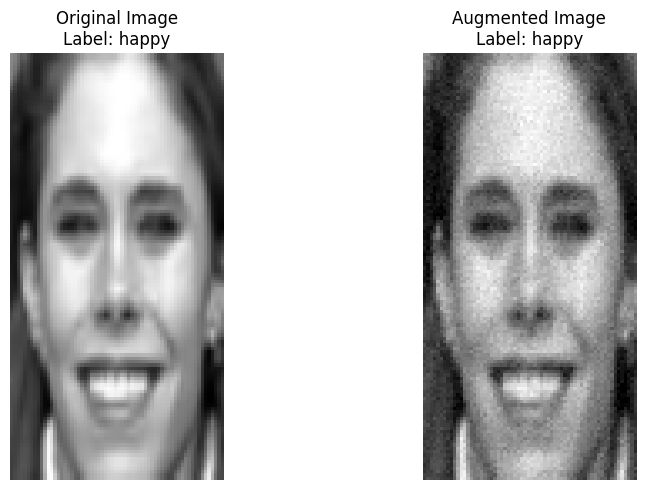

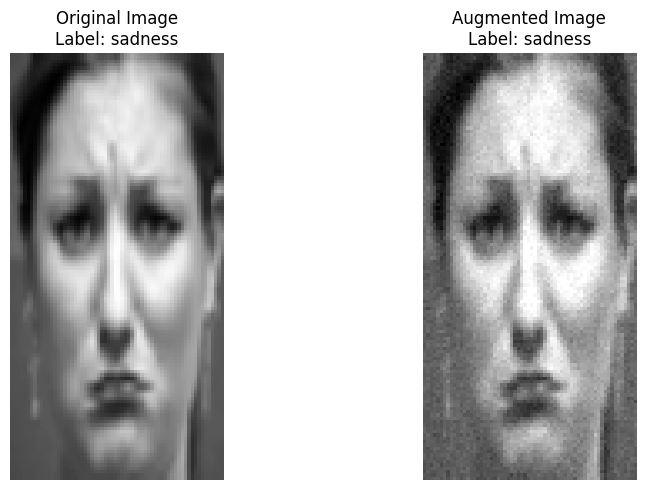

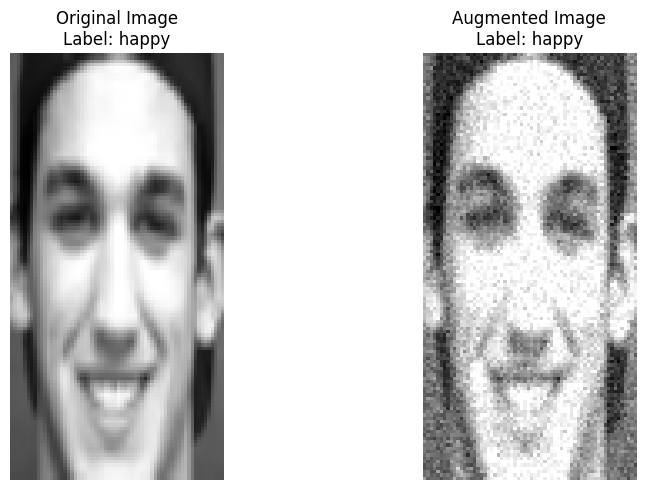

In [ ]:
# Number of sample images to display
num_samples = min(3, len(X_train))
print(num_samples)
for i in range(num_samples):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Get labels for the original and augmented images
    orig_label = y_train[i]
    aug_label = y_train_augmented[i]

    # Display Original Image with its label
    axes[0].imshow(X_train[i], cmap='gray')
    axes[0].set_title(f"Original Image\nLabel: {orig_label}")
    axes[0].axis("off")

    # Display Augmented Image with its label
    axes[1].imshow(X_train_augmented[i], cmap='gray')
    axes[1].set_title(f"Augmented Image\nLabel: {aug_label}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
def extract_hog_features(image):
    features = hog(image,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2',
                   visualize=False)
    return features

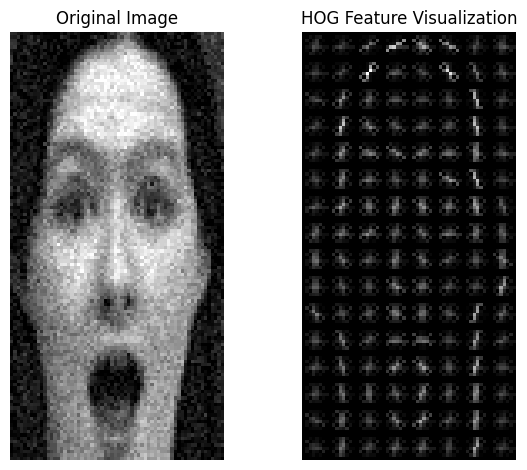

In [ ]:
sample_image = X_train_combined[1101]

features, hog_image = hog(sample_image,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2',
                          visualize=True)

plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# HOG visualization
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Feature Visualization")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# For training data.
hog_features_train = [extract_hog_features(img) for img in X_train_combined]
X_train_features = np.array(hog_features_train)

# For test data.
hog_features_test = [extract_hog_features(img) for img in X_test]
X_test_features = np.array(hog_features_test)

print("HOG feature extraction complete.")

HOG feature extraction complete.


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

In [ ]:
def plot_confusion_matrices(confusion_matrices, kernels, class_names=None):
    n_kernels = len(kernels)
    fig, axes = plt.subplots(1, n_kernels, figsize=(6 * n_kernels, 4))

    # If there's only one kernel, wrap it in a list
    if n_kernels == 1:
        axes = [axes]

    for idx, kernel in enumerate(kernels):
        cm = confusion_matrices[kernel]
        if class_names is None:
            classes = [str(i) for i in range(cm.shape[0])]
        else:
            classes = class_names

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=classes, yticklabels=classes,
                    ax=axes[idx])
        axes[idx].set_title(f"Kernel: {kernel}")
        axes[idx].set_xlabel("Predicted")
        axes[idx].set_ylabel("True")

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_learning_curve(estimator, X, y, cv, title, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Number of Training Examples")
    plt.ylabel("Accuracy Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="CV score")
    plt.legend(loc="best")
    plt.show()

In [ ]:
def evaluate_svm_kernels_cv(X_train, y_train, X_test, y_test, kernels, class_names=None, cv_folds=5):
    confusion_matrices = {}
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=34)

    for kernel in kernels:
        print("=" * 60)
        print(f"Training & Evaluating SVM with kernel = '{kernel}'")
        print("=" * 60)

        # Create SVM model with default parameters for this kernel
        model = SVC(kernel=kernel, C=10, gamma='scale', random_state=34)

        # Cross validate on training set
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds)
        print(f"[CV] Mean Accuracy: {cv_scores.mean()*100:.2f}%")

        # Plot learning curve for current kernel
        plot_learning_curve(model, X_train, y_train, cv=cv,
                            title=f"Learning Curve for SVM ({kernel} Kernel)")

        # Evaluate on training set
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        train_acc = accuracy_score(y_train, y_pred_train)
        print("[TRAIN] Accuracy: {:.2f}%".format(train_acc * 100))
        print("[TRAIN] Classification Report:")
        print(classification_report(y_train, y_pred_train, target_names=class_names))

        # Evaluate on test set
        y_pred_test = model.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred_test)
        print("[TEST]  Accuracy: {:.2f}%".format(test_acc * 100))
        print("[TEST]  Classification Report:")
        print(classification_report(y_test, y_pred_test, target_names=class_names))

        # Store the confusion matrix
        cm = confusion_matrix(y_test, y_pred_test)
        confusion_matrices[kernel] = cm
        print("\n")

    print("**** COMPARISON: Confusion Matrices for Each Kernel (TEST set) ****")
    plot_confusion_matrices(confusion_matrices, kernels, class_names)


Training & Evaluating SVM with kernel = 'linear'
[CV] Mean Accuracy: 97.81%


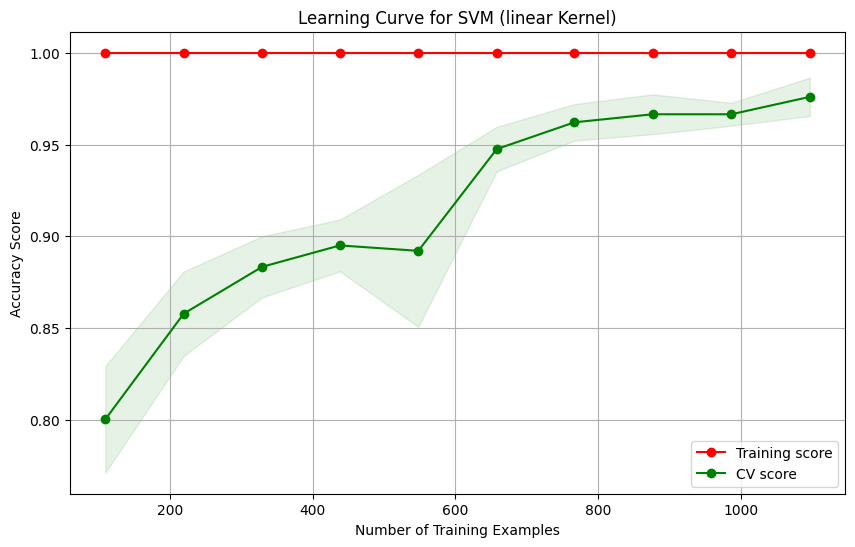

[TRAIN] Accuracy: 100.00%
[TRAIN] Classification Report:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00       188
    contempt       1.00      1.00      1.00        76
     disgust       1.00      1.00      1.00       248
        fear       1.00      1.00      1.00       104
       happy       1.00      1.00      1.00       290
     sadness       1.00      1.00      1.00       118
    surprise       1.00      1.00      1.00       348

    accuracy                           1.00      1372
   macro avg       1.00      1.00      1.00      1372
weighted avg       1.00      1.00      1.00      1372

[TEST]  Accuracy: 98.64%
[TEST]  Classification Report:
              precision    recall  f1-score   support

       anger       0.91      1.00      0.95        41
    contempt       1.00      1.00      1.00        16
     disgust       1.00      1.00      1.00        53
        fear       1.00      0.87      0.93        23
       happy       

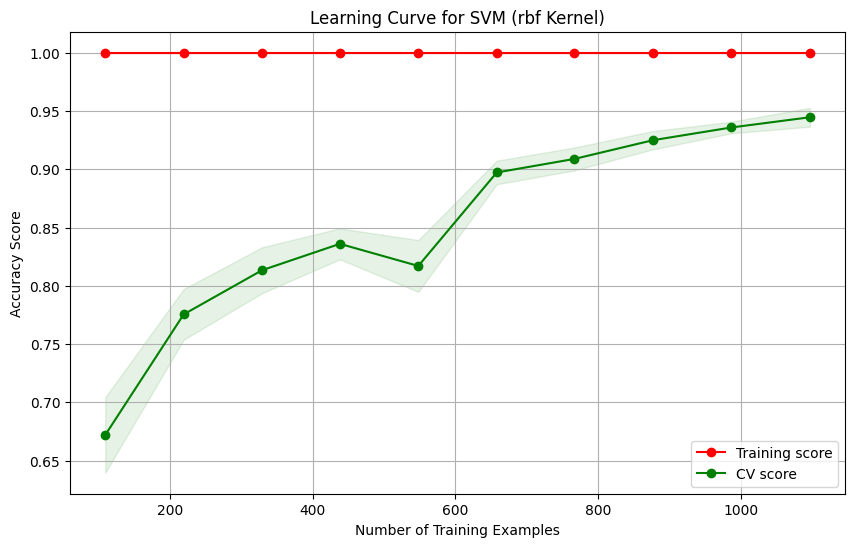

[TRAIN] Accuracy: 100.00%
[TRAIN] Classification Report:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00       188
    contempt       1.00      1.00      1.00        76
     disgust       1.00      1.00      1.00       248
        fear       1.00      1.00      1.00       104
       happy       1.00      1.00      1.00       290
     sadness       1.00      1.00      1.00       118
    surprise       1.00      1.00      1.00       348

    accuracy                           1.00      1372
   macro avg       1.00      1.00      1.00      1372
weighted avg       1.00      1.00      1.00      1372

[TEST]  Accuracy: 98.98%
[TEST]  Classification Report:
              precision    recall  f1-score   support

       anger       0.93      1.00      0.96        41
    contempt       1.00      1.00      1.00        16
     disgust       1.00      1.00      1.00        53
        fear       1.00      0.87      0.93        23
       happy       

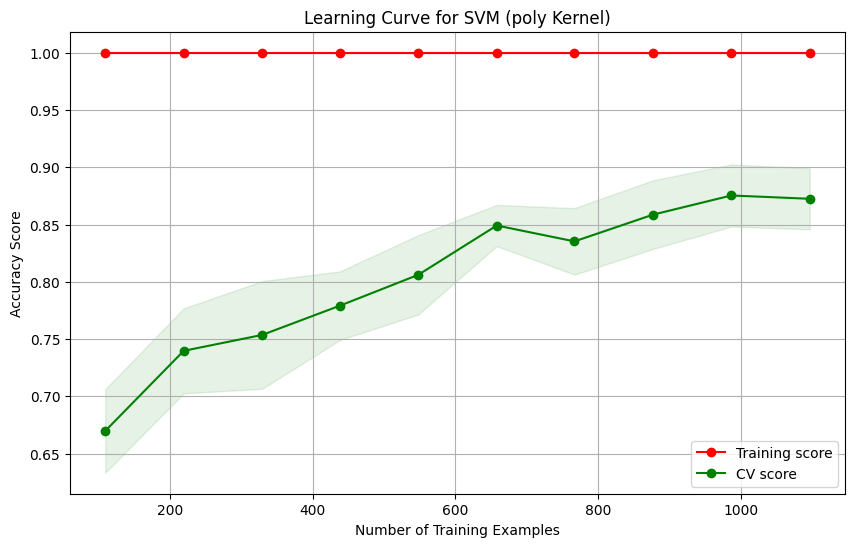

[TRAIN] Accuracy: 100.00%
[TRAIN] Classification Report:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00       188
    contempt       1.00      1.00      1.00        76
     disgust       1.00      1.00      1.00       248
        fear       1.00      1.00      1.00       104
       happy       1.00      1.00      1.00       290
     sadness       1.00      1.00      1.00       118
    surprise       1.00      1.00      1.00       348

    accuracy                           1.00      1372
   macro avg       1.00      1.00      1.00      1372
weighted avg       1.00      1.00      1.00      1372

[TEST]  Accuracy: 98.98%
[TEST]  Classification Report:
              precision    recall  f1-score   support

       anger       0.93      1.00      0.96        41
    contempt       1.00      1.00      1.00        16
     disgust       1.00      1.00      1.00        53
        fear       1.00      0.87      0.93        23
       happy       

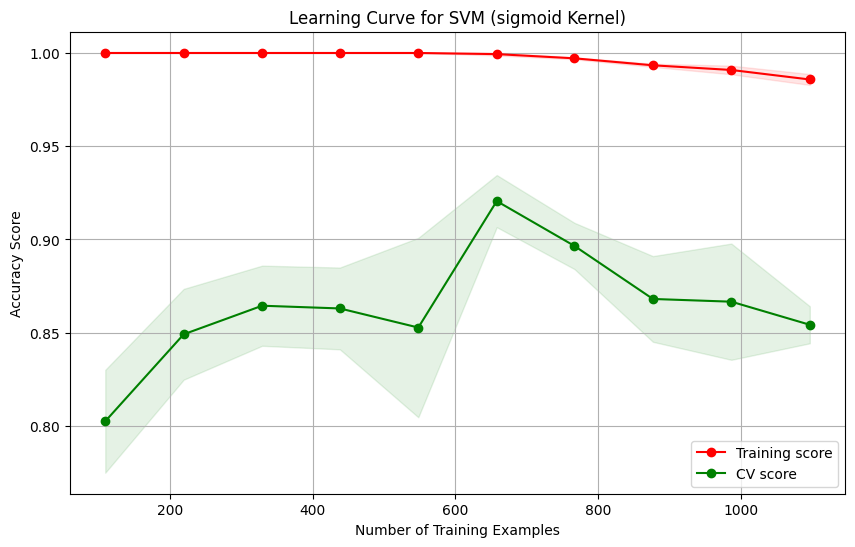

[TRAIN] Accuracy: 98.25%
[TRAIN] Classification Report:
              precision    recall  f1-score   support

       anger       0.99      0.96      0.98       188
    contempt       0.99      0.95      0.97        76
     disgust       1.00      0.98      0.99       248
        fear       0.97      1.00      0.99       104
       happy       0.94      1.00      0.97       290
     sadness       1.00      0.97      0.98       118
    surprise       1.00      0.99      1.00       348

    accuracy                           0.98      1372
   macro avg       0.98      0.98      0.98      1372
weighted avg       0.98      0.98      0.98      1372

[TEST]  Accuracy: 97.63%
[TEST]  Classification Report:
              precision    recall  f1-score   support

       anger       0.85      1.00      0.92        41
    contempt       1.00      0.94      0.97        16
     disgust       1.00      0.98      0.99        53
        fear       1.00      0.87      0.93        23
       happy       1

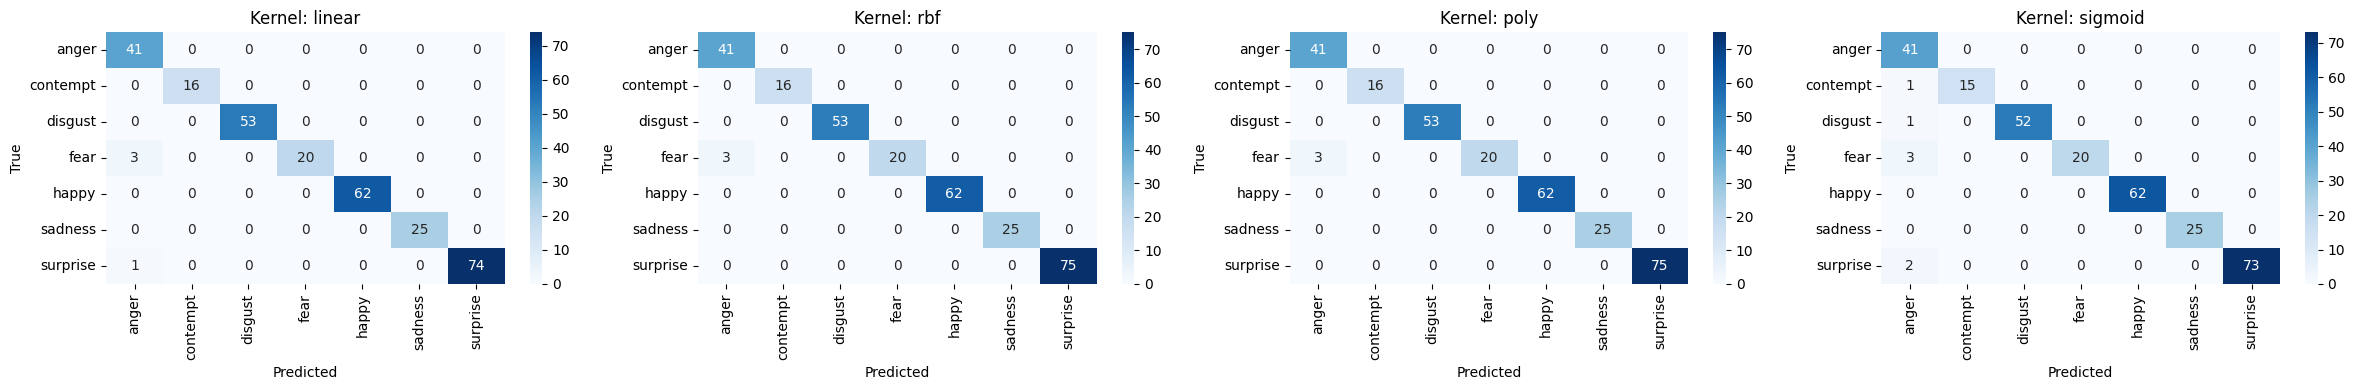

In [ ]:
# Define the kernels to evaluate.
kernels = ["linear", "rbf", "poly", "sigmoid"]
class_names = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

# Evaluate SVM with the specified kernels.
evaluate_svm_kernels_cv(X_train_scaled, y_train_combined, X_test_scaled, y_test, kernels, class_names=class_names)

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler


# Define the parameter ranges using np.logspace.
C_range = np.logspace(-2, 10, 5)
gamma_range = np.logspace(-9, 3, 5)

# Define the parameter grid for SVM with a polynomial kernel.
param_grid_poly = {
    'C': C_range,
    'degree': [2, 3, 4, 5],
    'gamma': gamma_range,
    'coef0': [0.0, 0.1, 0.5, 1.0]
}

# Create an SVM instance with the polynomial kernel.
svm_poly = SVC(kernel='poly', random_state=42)

# Set up GridSearchCV with 5-fold cross-validation.
grid_search_poly = GridSearchCV(svm_poly, param_grid_poly, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the training data.
grid_search_poly.fit(X_train_scaled, y_train_combined)

# Output the best parameters and cross-validation score.
print("Best parameters found for SVM with polynomial kernel:")
print(grid_search_poly.best_params_)
print("Best cross-validation score: {:.2f}%".format(grid_search_poly.best_score_ * 100))

best_svm_poly = grid_search_poly.best_estimator_
test_accuracy = best_svm_poly.score(X_test_scaled, y_test)
print("Test set accuracy: {:.2f}%".format(test_accuracy * 100))


Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best parameters found for SVM with polynomial kernel:
{'C': 10000.0, 'coef0': 0.1, 'degree': 2, 'gamma': 1e-06}
Best cross-validation score: 97.96%
Test set accuracy: 98.98%


polynomial kernel (GridSearchCV tuned) Test Accuracy: 98.98%
Classification Report (GridSearchCV):
              precision    recall  f1-score   support

       anger       0.93      1.00      0.96        41
    contempt       1.00      1.00      1.00        16
     disgust       1.00      1.00      1.00        53
        fear       1.00      0.87      0.93        23
       happy       1.00      1.00      1.00        62
     sadness       1.00      1.00      1.00        25
    surprise       1.00      1.00      1.00        75

    accuracy                           0.99       295
   macro avg       0.99      0.98      0.98       295
weighted avg       0.99      0.99      0.99       295

Confusion Matrix (GridSearchCV):


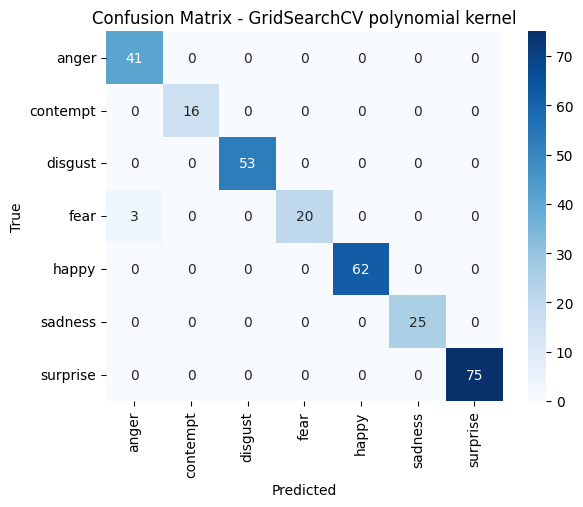

In [ ]:
y_pred_grid = grid_search_poly.predict(X_test_scaled)
acc_grid = accuracy_score(y_test, y_pred_grid)
print("polynomial kernel (GridSearchCV tuned) Test Accuracy: {:.2f}%".format(acc_grid * 100))
print("Classification Report (GridSearchCV):")
print(classification_report(y_test, y_pred_grid, target_names=class_names))
print("Confusion Matrix (GridSearchCV):")
cm_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(cm_grid, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - GridSearchCV polynomial kernel")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Baseline RandomForestClassifier (default parameters) Test Accuracy: 92.88%
Classification Report (Baseline):
              precision    recall  f1-score   support

       anger       0.85      0.95      0.90        41
    contempt       1.00      0.56      0.72        16
     disgust       0.96      0.96      0.96        53
        fear       0.90      0.78      0.84        23
       happy       0.91      1.00      0.95        62
     sadness       0.96      0.88      0.92        25
    surprise       0.96      0.97      0.97        75

    accuracy                           0.93       295
   macro avg       0.93      0.87      0.89       295
weighted avg       0.93      0.93      0.93       295

Confusion Matrix (Baseline):


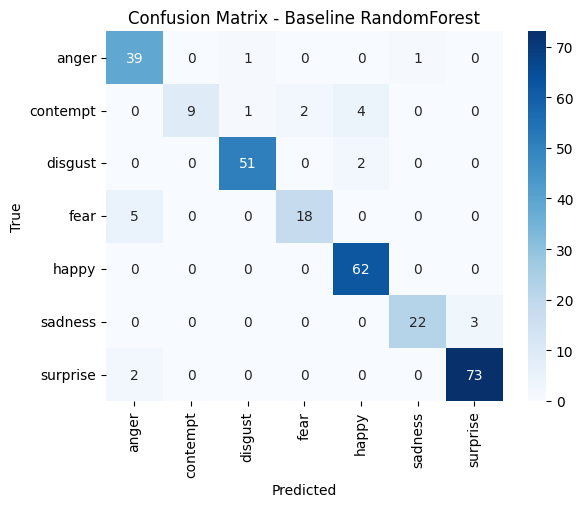

In [ ]:
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train_scaled, y_train_combined)
y_pred_baseline = rf_default.predict(X_test_scaled)

acc_baseline = accuracy_score(y_test, y_pred_baseline)
print("Baseline RandomForestClassifier (default parameters) Test Accuracy: {:.2f}%".format(acc_baseline * 100))
print("Classification Report (Baseline):")
print(classification_report(y_test, y_pred_baseline, target_names=class_names))
print("Confusion Matrix (Baseline):")
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Baseline RandomForest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from Grid Search: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestClassifier (GridSearchCV tuned) Test Accuracy: 93.22%
Classification Report (GridSearchCV):
              precision    recall  f1-score   support

       anger       0.84      0.93      0.88        41
    contempt       1.00      0.62      0.77        16
     disgust       0.95      1.00      0.97        53
        fear       1.00      0.70      0.82        23
       happy       0.95      1.00      0.98        62
     sadness       0.96      0.88      0.92        25
    surprise       0.93      0.99      0.95        75

    accuracy                           0.93       295
   macro avg       0.95      0.87      0.90       295
weighted avg       0.94      0.93      0.93       295

Confusion Matrix (GridSearchCV):


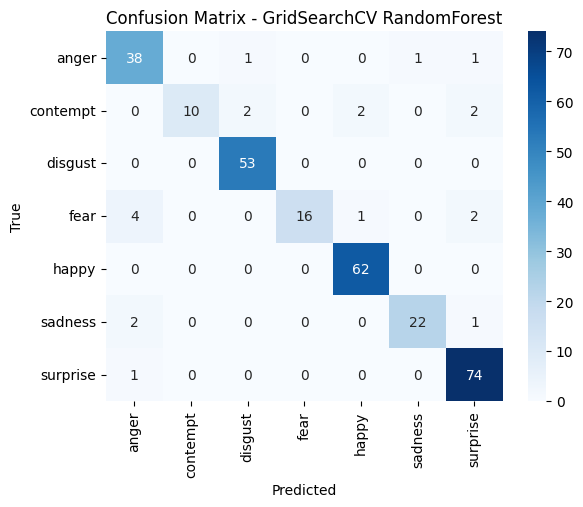

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train_scaled, y_train_combined)

print("Best parameters from Grid Search:", grid_rf.best_params_)

y_pred_grid = grid_rf.predict(X_test_scaled)
acc_grid = accuracy_score(y_test, y_pred_grid)
print("RandomForestClassifier (GridSearchCV tuned) Test Accuracy: {:.2f}%".format(acc_grid * 100))
print("Classification Report (GridSearchCV):")
print(classification_report(y_test, y_pred_grid, target_names=class_names))
print("Confusion Matrix (GridSearchCV):")
cm_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(cm_grid, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - GridSearchCV RandomForest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


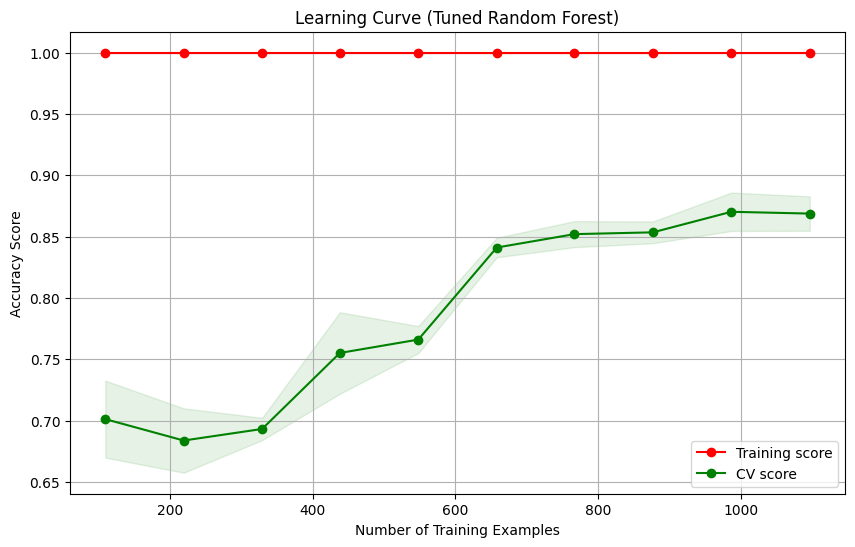

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot the learning curve for the tuned Random Forest
plot_learning_curve(grid_rf, X_train_scaled, y_train_combined,
                   title="Learning Curve (Tuned Random Forest)", cv=cv)

In [ ]:
# For training data.
hog_features_train = [extract_hog_features(img) for img in X_train]
X_train_features_base = np.array(hog_features_train)

# For test data.
hog_features_test = [extract_hog_features(img) for img in X_test]
X_test_features_base = np.array(hog_features_test)

print("HOG feature extraction complete.")


HOG feature extraction complete.


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features_base)
X_test_scaled = scaler.transform(X_test_features_base)

Training & Evaluating SVM with kernel = 'linear'
[CV] Mean Accuracy: 97.96%
[TRAIN] Accuracy: 100.00%
[TRAIN] Classification Report:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        94
    contempt       1.00      1.00      1.00        38
     disgust       1.00      1.00      1.00       124
        fear       1.00      1.00      1.00        52
       happy       1.00      1.00      1.00       145
     sadness       1.00      1.00      1.00        59
    surprise       1.00      1.00      1.00       174

    accuracy                           1.00       686
   macro avg       1.00      1.00      1.00       686
weighted avg       1.00      1.00      1.00       686

[TEST]  Accuracy: 98.98%
[TEST]  Classification Report:
              precision    recall  f1-score   support

       anger       0.93      1.00      0.96        41
    contempt       1.00      1.00      1.00        16
     disgust       1.00      1.00      1.00        

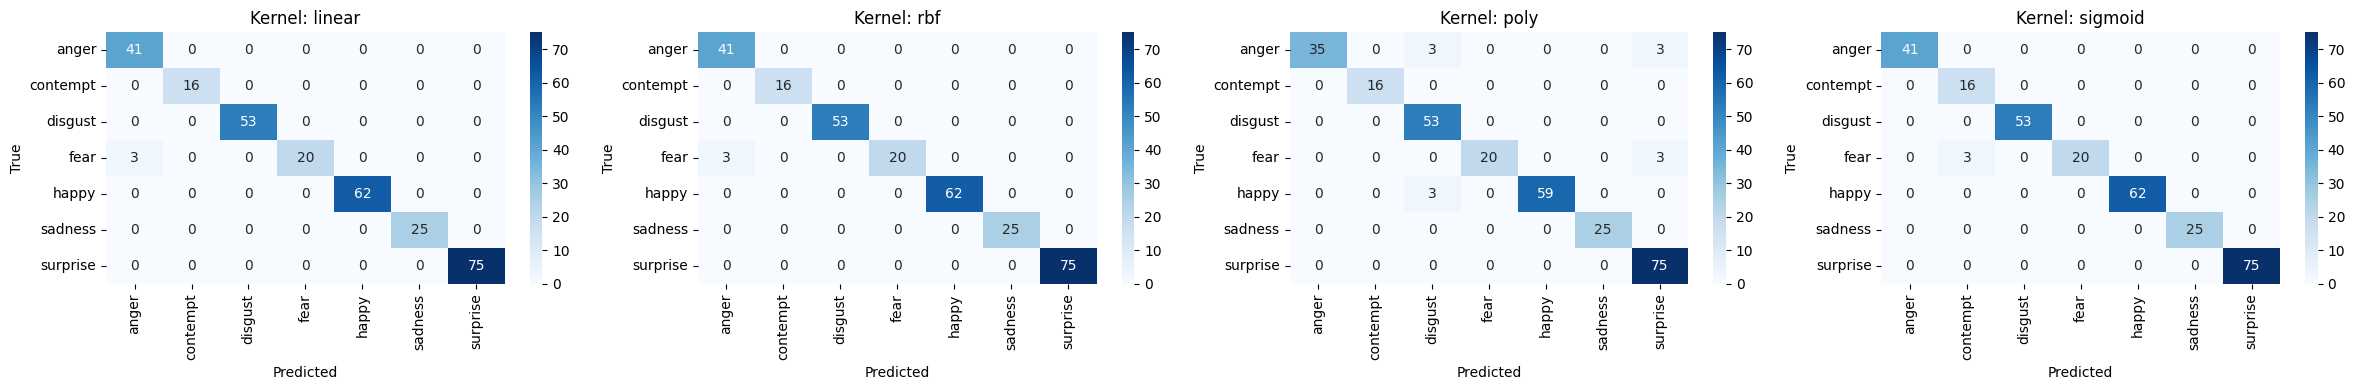

In [ ]:
# Define the kernels to evaluate.
kernels = ["linear", "rbf", "poly", "sigmoid"]
class_names = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

# Evaluate SVM with the specified kernels.
evaluate_svm_kernels_cv(X_train_scaled, y_train, X_test_scaled, y_test, kernels, class_names=class_names)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from Grid Search: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestClassifier (GridSearchCV tuned) Test Accuracy: 96.61%
Classification Report (GridSearchCV):
              precision    recall  f1-score   support

       anger       0.89      0.95      0.92        41
    contempt       1.00      0.88      0.93        16
     disgust       1.00      1.00      1.00        53
        fear       1.00      0.78      0.88        23
       happy       0.97      1.00      0.98        62
     sadness       1.00      1.00      1.00        25
    surprise       0.96      0.99      0.97        75

    accuracy                           0.97       295
   macro avg       0.97      0.94      0.96       295
weighted avg       0.97      0.97      0.97       295

Confusion Matrix (GridSearchCV):


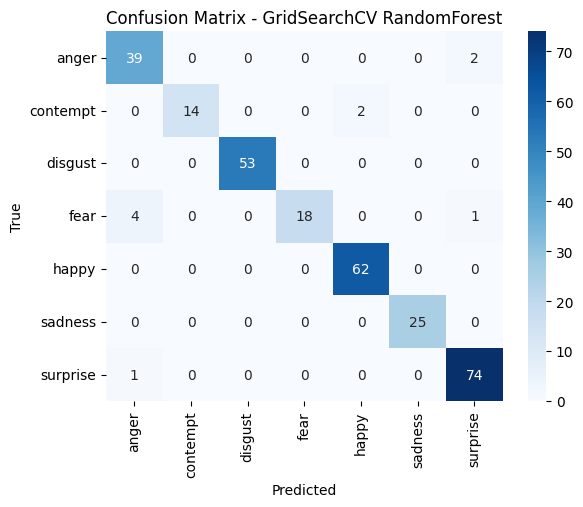

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train_scaled, y_train)

print("Best parameters from Grid Search:", grid_rf.best_params_)

y_pred_grid = grid_rf.predict(X_test_scaled)
acc_grid = accuracy_score(y_test, y_pred_grid)
print("RandomForestClassifier (GridSearchCV tuned) Test Accuracy: {:.2f}%".format(acc_grid * 100))
print("Classification Report (GridSearchCV):")
print(classification_report(y_test, y_pred_grid, target_names=class_names))
print("Confusion Matrix (GridSearchCV):")
cm_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(cm_grid, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - GridSearchCV RandomForest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()